# Emotiv EEG Data Visualization Options

A short overview of what's possible with the MNE library and what we should focus on including into the first iteration of the BrainWaves app.



In [220]:
from mne import Epochs, find_events, set_eeg_reference, read_epochs, viz, combine_evoked
from time import time, strftime, gmtime
from collections import OrderedDict
from glob import glob
from collections import OrderedDict
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'app','utils','jupyter'))
import utils
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

This is a dataset that has been collected and cleaned in the app. It is comprised of two 2-minute runs of the Faces Houses experiment and, although it doesn't show a classic N170, there is some interesting event-related potential information in the data. It actually looks like there may be P300s.

In [182]:
epochs = read_epochs('/home/dano/BrainWaves Workspaces/Dano Nelson Faces Houses/Data/Subash_2-epo.fif')
face_epochs = epochs['Face']
house_epochs = epochs['House']

Reading /home/dano/BrainWaves Workspaces/Dano Nelson Faces Houses/Data/Subash_2-epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     796.88 ms
        0 CTF compensation matrices available
157 matching events found
Applying baseline correction (mode: mean)
157 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [183]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mne.datasets import sample
from mne import read_evokeds

house_evoked = house_epochs.average()
face_evoked = face_epochs.average()

The way I see it, the students have to demonstrate that they can make three types of comparisons on this screen: comparing between conditions (faces and house, etc.), comparing between channels, and comparing between subjects. This gets a bit complicated because the comparisons between channels and subjects should really be based on the *difference between conditions that they've found by comparing between conditions*

I've broken up the different visualizations into these different 'jobs'. I'm not sure which order these tasks should necessarily be completed, but I'm putting them in the order that makes most sense for how I would explore a dataset.

# Job 1: Comparing Between Conditions

## Averaged Epoch Difference Plot

This is our standard, which is good at showing differences between conditions with statistical significance indicated by the colored background confidence interval.

However, it kind of sucks because it only displays one channel at a time

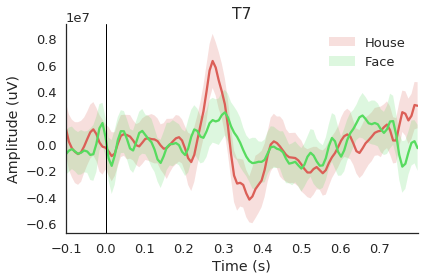

In [197]:
# Computation
conditions = OrderedDict({key: [value] for (key, value) in event_id.items()})

# Output
X, y = utils.plot_conditions(epochs, ch_ind=4, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='', diff_waveform=None)

## Epochs Spectrogram

This is the first new interesting viz we could consider using. The colors correspond to the amplitude of the EEG, with red being positive and blue being negative. The epochs are all lined up in rows on the y axis and ERPs should be visible as vertical colored bands.

Unfortunately, here we also can only view one plot at a time

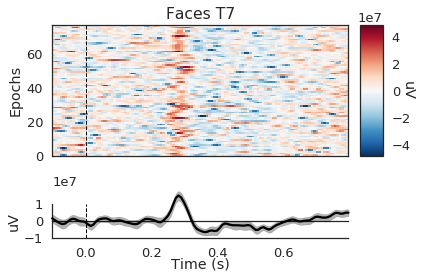

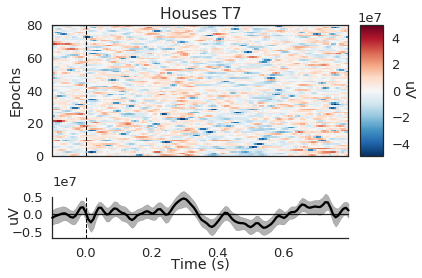

[<Figure size 432x288 with 3 Axes>]

In [185]:
face_epochs.plot_image(title="Faces T7",picks=[3])
house_epochs.plot_image(title="Houses T7",picks=[3])

## Joint Plot
This is a very cool plot that I just discovered. Essentially, it has all the potential comparisons we could make in one plot. The colored lines show each channels average epoch stacked on top of each other ('Butterfly plot'). In addition, there is an algorithm that will automatically find peaks (3 by default) in the data, mark those times, and display a topomap of the EEG at that point in time.

I think this could be a great plot to use, but it may be a little overwhelming without much instruction.

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


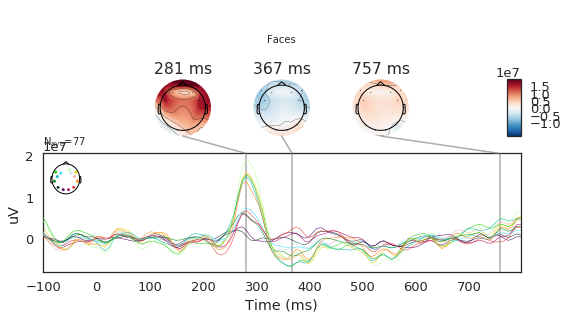

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


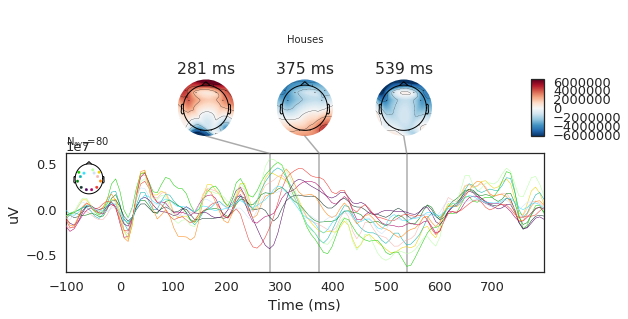

In [227]:
ace_evoked.plot_joint(times="peaks", title="Faces");
house_evoked.plot_joint(times="peaks", title="Houses");

## Evoked power comparison

This is an interesting plot that could be used for comparing directly between conditions. It averages over all channels to compute global field power and plots the difference between conditions

Will have to spend more time figuring out how to add legend. A nice example is here: https://martinos.org/mne/stable/auto_tutorials/plot_visualize_evoked.html

No picks, plotting the GFP ...


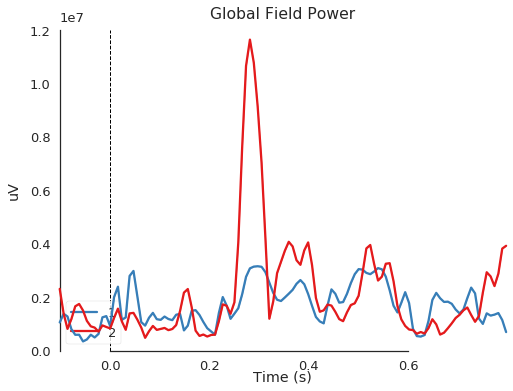

In [209]:
viz.plot_compare_evokeds([house_evoked, face_evoked]);

# Job 2: Comparing Between Channels

These should help students pick out which channels are showing the most powerful ERPs and interesting effects

## Topographic Map of Averaged Epochs
I think this is a fun one that will correspond nicely with our head diagram. All the averaged epochs are spaced out like the electrodes are.

Unfortunately, there isn't a convenient way to plot both conditions together on the same map. The best I can do is plot the difference epochs

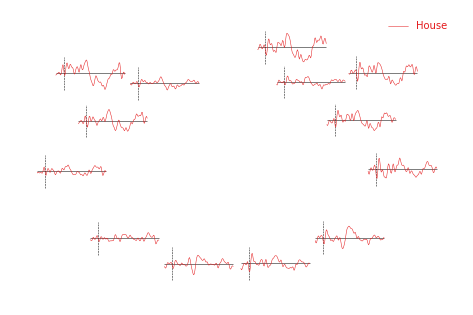

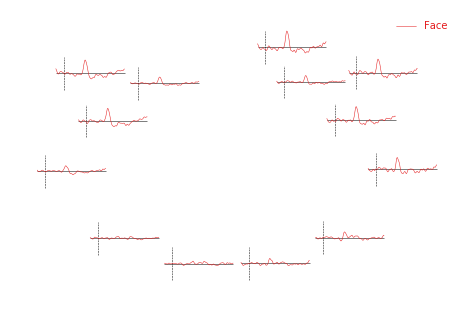

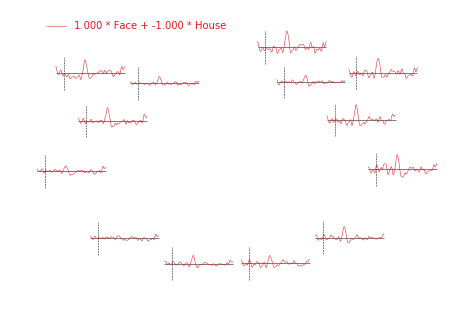

In [226]:
diff_evoked = combine_evoked([face_evoked, house_evoked], weights=[1, -1])
house_evoked.plot_topo();
face_evoked.plot_topo();
diff_evoked.plot_topo();

## Averaged Epochs Spectrogram

I think this is the easiest way to pick out which channels contained an ERP. However, it's a little bit more complex than a spatial map. Not sure how to go from channel index to channel name, though (I think it's possible, though)

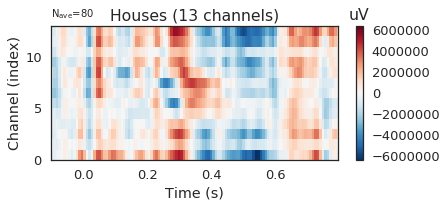

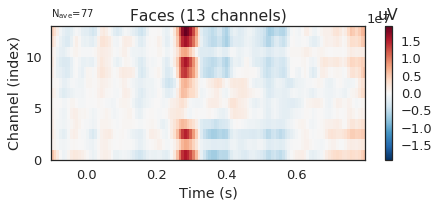

In [153]:
house_evoked.plot_image(titles="Houses", time_unit="s");
face_evoked.plot_image(titles="Faces", time_unit="s");

## Topomap Series

This is a decent way to show what's happening in the different electrode locations during the epoch. However, I think it's prone to displaying a lot of info that's prone to being misinterpreted by students. This kind of viz will also be nearly useless for the Muse because of its low channel count

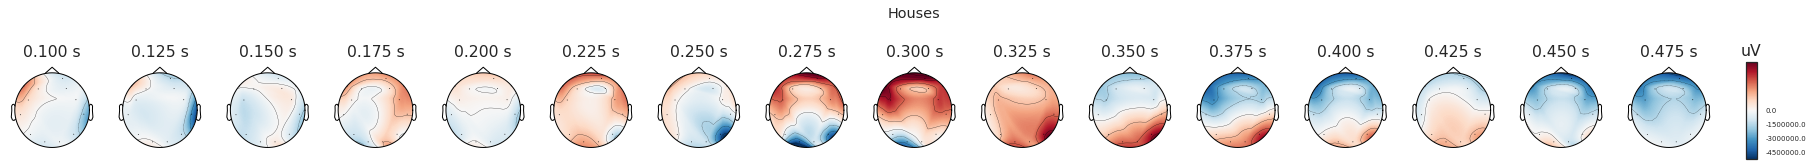

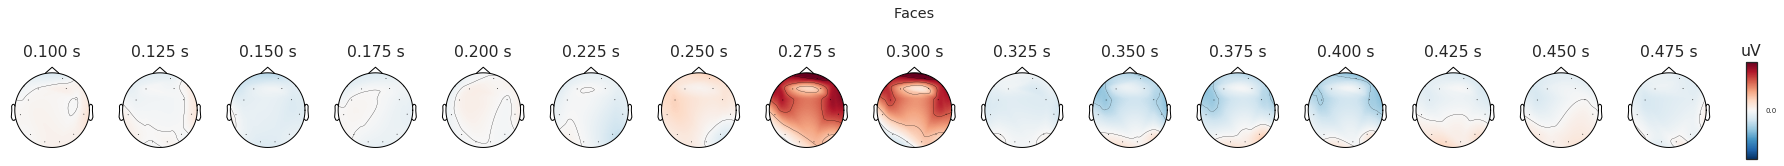

In [136]:

# set time instants in seconds (from 50 to 150ms in a step of 10ms)
times = np.arange(0.1, 0.5, 0.025)
# compute a 50 ms bin to stabilize topographies
house_evoked.plot_topomap(times, title='Houses',  ch_type='eeg', average=0.025, time_unit='s');
face_evoked.plot_topomap(times, title='Faces',  ch_type='eeg', average=0.025, time_unit='s');


# Job 3: Comparing Between Subjects

Once students have an idea of when and where their findings ERPs, it would be easy to compare between subjects by reusing any of the above graphs. 

It might be nice to help them out and convert to using visualizations of the difference ERP in such circumstances, though that may be confusing

# Statistical Signficance

At the end of the day, we need to teach the students about statistically signifance for their projects. There's two ways I think we can do that.

The first would be to use the colored confidence interval bands in the Averaged Epoch Difference plots we've been using so far. If there is white space between the two conditions, that represents a difference with statistical signficance of P < 0.05.

The second would be to mask the Averaged Epochs Spectrogram to only reveal timepoints at which some statistical test passed. This could be a simple t test for difference P < 0.05 between Face and House ERPs. I didn't have time to code this, but it would look kind of like this (ignore the fact that there are three different plots for left, right, and midline)

![image](https://martinos.org/mne/stable/_images/sphx_glr_plot_stats_cluster_erp_002.png)